# PlantSegmentation 🌱 + 🔬 - AI4Science: Accelerating experimental loops

In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torchvision
from torchvision.transforms import ToTensor

from torch.utils.data import DataLoader

from dataset import PlantDataset 
from utils import (
    display_masks, 
    extract_ids_from_name, 
    extract_tag_from_name,
    upscale_logits, # quizas deberian ir al modulo del modelo?
    flatten_logits, # quizas deberian ir al modulo del modelo
    set_seed,
    )

from evaluation import compute_intersection_over_union

from transformers import (
    SegformerForSemanticSegmentation,
    SegformerFeatureExtractor
)

from matplotlib import cm
from PIL import Image 
from tqdm import tqdm

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


## `PlantDataset` 🌱: navegar por imágenes y máscaras

In [2]:
from dataset import PlantDataset, extract_ids_from_name

label2id = {'normal': 0, 'normal_cut': 1, 'noise': 2}
dataset = PlantDataset('data', 'cwt', 'data_inventary.csv', label2id=label2id)

Podemos verificar si `CellDataset` navega correctamente por el directorio
y carga los archivos correctos:

In [15]:
dataset[10]

{'image': <PIL.Image.Image image mode=RGB size=2503x1895>,
 'masks': ['data/cwt/original_labeled/11/task-11-annotation-53-by-1-tag-normal_cut-0.png',
  'data/cwt/original_labeled/11/task-11-annotation-47-by-1-tag-noise-0.png',
  'data/cwt/original_labeled/11/task-11-annotation-50-by-1-tag-noise-0.png',
  'data/cwt/original_labeled/11/task-11-annotation-51-by-1-tag-noise-0.png',
  'data/cwt/original_labeled/11/task-11-annotation-49-by-1-tag-noise-0.png',
  'data/cwt/original_labeled/11/task-11-annotation-52-by-1-tag-normal_cut-0.png',
  'data/cwt/original_labeled/11/task-11-annotation-46-by-1-tag-normal-0.png',
  'data/cwt/original_labeled/11/task-11-annotation-48-by-1-tag-noise-0.png'],
 'labels': [1, 2, 2, 2, 2, 1, 0, 2]}

The image corresponding to idx 4 has the file name 'cwt1_13.jpg'

The name of the folder where the masks are stored is 5, and there are 7 masks:
 -> data/cwt/original_labeled/5/task-5-annotation-24-by-1-tag-normal_cut-0.png
 -> data/cwt/original_labeled/5/task-5-annotation-22-by-1-tag-noise-0.png
 -> data/cwt/original_labeled/5/task-5-annotation-21-by-1-tag-noise-0.png
 -> data/cwt/original_labeled/5/task-5-annotation-23-by-1-tag-normal-0.png
 -> data/cwt/original_labeled/5/task-5-annotation-27-by-1-tag-noise-0.png
 -> data/cwt/original_labeled/5/task-5-annotation-25-by-1-tag-noise-0.png
 -> data/cwt/original_labeled/5/task-5-annotation-26-by-1-tag-noise-0.png
The labels of the masks are [1, 2, 2, 0, 2, 2, 2]


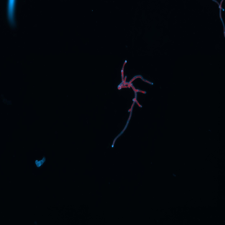

In [16]:
idx=4
img, masks, labels = dataset[idx].values()
print(f"The image corresponding to idx {idx} has the file name '{dataset.images[idx]}'\n")
name_original_img = dataset.images[idx]
id_original_img, id_after_split = extract_ids_from_name(name_original_img)
mask_idx = dataset.idx_table[(dataset.idx_table['id orginal img'] == id_original_img) & 
                             (dataset.idx_table['id after split'] == id_after_split)]['id']._values[0]

print(f"The name of the folder where the masks are stored is {mask_idx}, and there are {len(masks)} masks:")
for mn in masks:
    print(f" -> {mn}")
print(f"The labels of the masks are {labels}")
img.resize((225, 225))

Podemos visualizar las máscaras asociadas a esta imagen con la
función de utilidad `display_masks`.

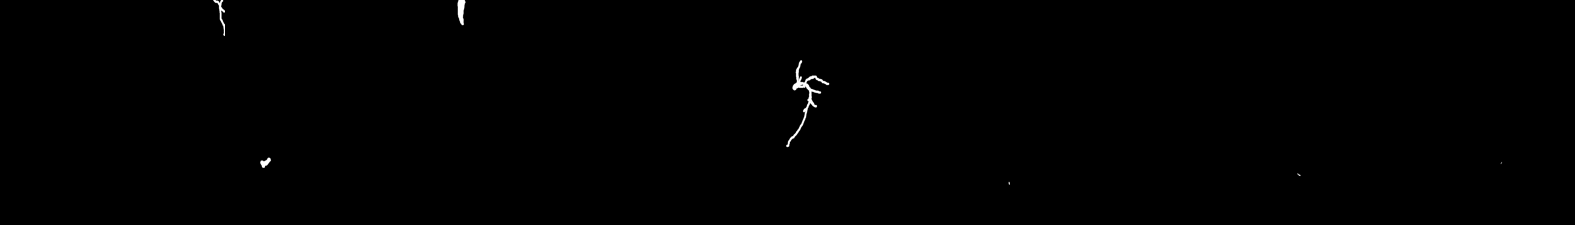

In [17]:
# TODO: analizar el orden de como se stackean las imagenes de la lista de direcciones en masks
# a la PIL.Image en display_masks()
from utils import display_masks
display_masks(masks)

De izquierda a derecha, cada máscara identifica las siguientes instancias.

In [18]:
for idx in labels:
    print(dataset._id2label[idx])

normal_cut
noise
noise
normal
noise
noise
noise


La clase `PlantDataset` contiene dos atributos con los diccionarios para
mapear la clase a un entero (i.e. `_label2id`) y viceversa (`_id2label`).

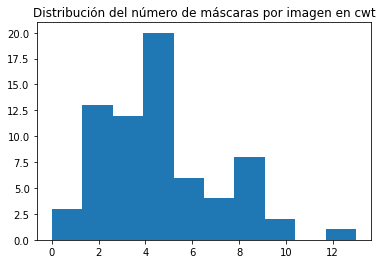

In [36]:
plt.hist(dataset.get_number_of_masks());
plt.title('Distribución del número de máscaras por imagen en cwt');

Hay una imagen con 13 máscaras asociadas...

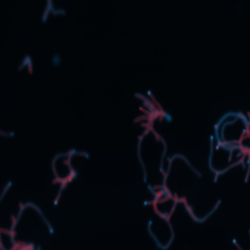

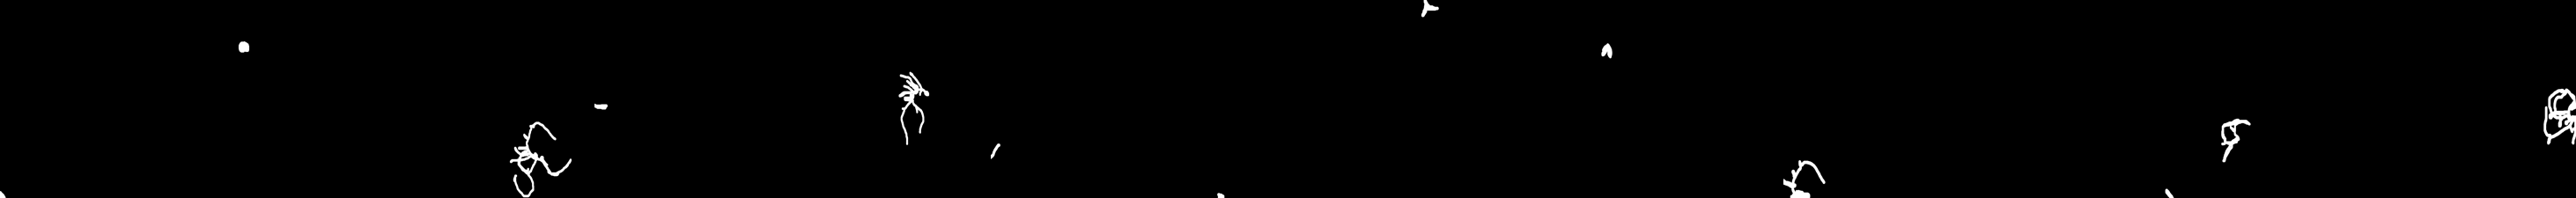

In [10]:
idx_13masks = dataset.get_number_of_masks().index(13)

display(dataset[idx_13masks]['image'].resize((250, 250)))

display_masks(dataset[idx_13masks]['masks'])

Podemos ver cuantas máscaras hay por clase con el método `dataset.get_masks_per_labels()`:

In [11]:
dataset.get_masks_per_labels()

(array(['noise', 'normal', 'normal_cut'], dtype='<U10'),
 array([119,  99,  98]))

## Collate Function + DataLoader: bonito, bonito, pero quiero tensores

### Un canal para cada etiqueta, un entero para cada instancia

Ahora nos enfocaremos en construir el _target_ de una observación. Necesitamos
crear un tensor a partir de todas las posibles máscaras y etiquetas asociadas
a una imagen, dentro del cual se identifican instancias particulares a una clase
dentro de la misma matriz. Tendremos 3 matrices, 1 por cada clase, y todas
apiladas en una dimensión adicional en el mismo tensor. Esto será el _target_
para cada imagen. 

In [12]:
# dado una imagen leer en tensores todas las etiquetas
idx=4
img, masks, labels = dataset[idx].values()
masks

['data/cwt/original_labeled/5/task-5-annotation-24-by-1-tag-normal_cut-0.png',
 'data/cwt/original_labeled/5/task-5-annotation-22-by-1-tag-noise-0.png',
 'data/cwt/original_labeled/5/task-5-annotation-21-by-1-tag-noise-0.png',
 'data/cwt/original_labeled/5/task-5-annotation-23-by-1-tag-normal-0.png',
 'data/cwt/original_labeled/5/task-5-annotation-27-by-1-tag-noise-0.png',
 'data/cwt/original_labeled/5/task-5-annotation-25-by-1-tag-noise-0.png',
 'data/cwt/original_labeled/5/task-5-annotation-26-by-1-tag-noise-0.png']

Usando un solo ejemplo, leemos sus máscaras y las transformamos a
tensores de PyTorch. Agrupamos todos los tensores asociados a una etiqueta,
tenemos 3 distintas, por lo tanto terminamos con 3 tensores que agrupan
en un canal todas las máscaras con la misma etiqueta.

In [13]:
from torchvision.transforms import ToTensor

# obtengamos la información para un ejemplo
idx=4
img, masks, labels = dataset[idx].values()

# crear id de instancias
instance_idxs = torch.tensor([l+1 for l in range(len(labels))], dtype=torch.long)
tfms = ToTensor()

# leer las mascaras por etiquetas, transformarlas a tensores, y concatenarlos en una dimensión
# adicional. Creamos un tensor por cada etiqueta
# TODO: cómo hacerlo todo una pasada?
R=(17,17)
m0 = torch.cat([torch.where(tfms(Image.open(m).resize(R)) > 0.0, 1.0, 0.0) * instance_idxs[l] for l, m in enumerate(masks) if labels[l] == 0])
m1 = torch.cat([torch.where(tfms(Image.open(m).resize(R)) > 0.0, 1.0, 0.0) * instance_idxs[l] for l, m in enumerate(masks) if labels[l] == 1])
m2 = torch.cat([torch.where(tfms(Image.open(m).resize(R)) > 0.0, 1.0, 0.0) * instance_idxs[l] for l, m in enumerate(masks) if labels[l] == 2])
m0.shape, m1.shape, m2.shape

(torch.Size([1, 17, 17]), torch.Size([1, 17, 17]), torch.Size([5, 17, 17]))

Notemos que la etiqueta asociada al índice 2 (i.e. `noise`) tiene 5 máscaras
asociadas, las otras dos etiquetas solo una. Necesitamos ahora fundir cada
uno de estos tensores con 3 dimensiones `(mask_id, height, width)` a 
`(height, width)` donde en cada pixel haya un número asociado a la instancia.

Partamos con el tensor que agrupa las máscaras `noise` y tiene 5 instancais
asociadas.

In [14]:
# revisamos sus ids de instancia
print('Id de instancia:', instance_idxs)
m2.unique()

Id de instancia: tensor([1, 2, 3, 4, 5, 6, 7])


tensor([0., 2., 3., 5., 6., 7.])

Recordemos que el valor 0 esta reservado para la etiqueta de ausencia (no label).
Así que las instancias parten desde el 1, ..., a tantas máscaras tenga asociada
la observación. No tienen porque tener un orden asociado según la clase.

Ahora podemos colapsar el canal que tiene cada mascara en una sola, sumando
todas las matrices a lo largo de este canal, element por elemento. Asumiendo
que no tenemos ninguna instancia asolapada, cada pixel debería tener un id
identificando a la máscara particular que pertenece. El resto de los valores
será 0 que significa que no hay ningúna clase que identificamos en ese pixel.

Recordemos que en nuestro ejemplo reducimos la resolución de las máscaras a
10x10 para lograr visualizarlas completa. Estas son las máscaras asociadas
a la etiqueta 2 que es `noise`. Originalmente habían 5 de 7 máscaras en
esta observación que se identifican a esta etiqueta. Sin embargo, en su 
versión matricial solo vemos 4 enteros distintos, esto es porque uno 
se perdió por la reducción de tamaño de imagen. 

Veámos las clases de cada máscara y los ids para identificar a cada una 
de ellas.

In [15]:
m0.sum(dim=0)

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 4., 4., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 4., 4., 4., 4., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 4., 4., 4., 4., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 4., 4., 4., 4., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 4., 4., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 4., 4., 4., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 4., 4., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 4., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

Si vemos la imagen a clasificar, es posible identificar con los
enteros de la matriz de arriba las zonas donde se clasificaron 
como ruído. Por la resolución, hay un par de puntos que son díficiles
de ver, pero las instancias representadas por 3 y 2 son fáciles de mapear
de la matriz a la imagen.

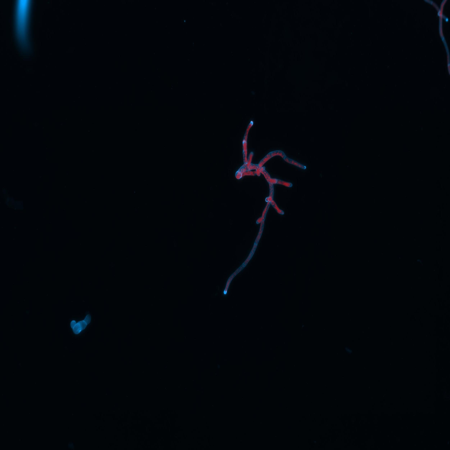

In [16]:
img.resize((450,450))

Este procedimiento se debe realizar por cada clase, luego debemos
apilar 3 matrices como la de arriba, en un solo tensor que tendrá
las dimensiones `(Batch, Clase, Altura, Ancho)`, y serán nuestras etiquetas
asociadas a la observación. 

A continuación una representación visual de lo que estamos haciendo pero
con más clases (Fuente: [Jemery Jordan Blog](https://www.jeremyjordan.me/semantic-segmentation/#:~:text=The%20most%20commonly%20used%20loss,one%2Dhot%20encoded%20target%20vector)).

![Source: Fuente Jeremy Jordan Blog](https://www.jeremyjordan.me/content/images/2018/05/Screen-Shot-2018-05-16-at-9.36.00-PM.png)

In [17]:
def get_target(masks, labels, tfms, size=(250, 250), num_classes=4):
    """ 
        Recibe una lista de máscaras y una lista de etiquetas, retorna
        un tensor de dimensiones (n_classes, height, widht). En cada clase,
        cualquier entero distinto a 0 representa a uns instancia particular
        de la clase. El entero 0 se reserva para background/no-clase.
    """
    # creamos tensor para almacenar máscaras por clase en cada canal (dim 1)
    # NOTA: la última es ausencia o ninguna detecctión 
    out = torch.zeros((1, num_classes, size[0], size[1]))

    # si no hay máscaras, retornamos el tensor
    if len(masks) == 0:
        return out

    # crear un entero que represente cada instancia de las mascaras asociadas
    # a la observación. No siguen un orden necesario tipo todas las de la clase 0
    # parten al principio, se encuentran según el orden de los labels. El entero
    # 0 se reserva como background/no-clase
    instance_idxs = torch.tensor([l+1 for l in range(len(labels))], dtype=torch.long)

    # iteramos sobre cada clase para procesar las máscaras asociadas a estas,
    # agregar un identificador de instancias y colapsar en una sola matriz
    # Supuesto: no hay clase sobrelapadas. Si hay, se debe hacer un proceso
    # adicional para ver que entero se asigna al pixel correspondiente
    for l in list(set(labels)):
        x = torch.cat([torch.where(tfms(Image.open(m).resize(size)) > 0.0, 1.0, 0.0) * instance_idxs[i] for i, m in enumerate(masks) if labels[i] == l])
        out[0, l, :, :] = x.sum(dim=0)

    return out

In [18]:
idx=4
img, masks, labels = dataset[idx].values()
tensor_mask = get_target(masks, labels, tfms, size=((10, 10)))
print(tensor_mask.shape)
tensor_mask

torch.Size([1, 4, 10, 10])


tensor([[[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 4., 0., 0., 0., 0.],
          [0., 0., 0., 0., 4., 4., 4., 4., 0., 0.],
          [0., 0., 0., 0., 0., 4., 4., 0., 0., 0.],
          [0., 0., 0., 0., 4., 4., 4., 0., 0., 0.],
          [0., 0., 0., 0., 4., 4., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],

         [[0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          

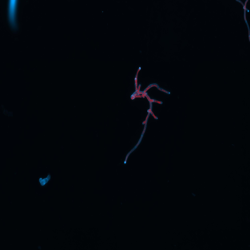

In [19]:
img.resize((250, 250))

### Targets binarios

En esta sección se crea etiquetas para detectar una clase o no. Es decir,
de las $X$ potenciales clases, solo nos interesa detectar una de ellas.

In [20]:
def get_binary_target(masks, labels, tfms, size=(250, 250)):
    """ 
        Recibe una lista de máscaras y una lista de etiquetas, retorna
        un tensor de dimensiones (1, height, width). La clase target_id
        se identificar con el entero 1, el resto es representado por
        el entero 0 (es decir background o noise)

        label 0 -> "normal" (ver dataset._id2label con mapping id - etiqueta)
    """
    target_id = 0
    out = torch.zeros((1, 1, size[0], size[1]))

    # si no hay máscaras o la clase a detectar no tiene máscara, retornamos el tensor
    if len(masks) == 0 or target_id not in (labels):
        return out
    
    target_masks_idx = np.where(np.array(labels) == target_id)[0]

    target_masks=[]
    for idx in target_masks_idx:
        target_masks.append(torch.where(tfms(Image.open(masks[idx]).resize(size)) > 0.0, 1.0, 0.0))
    out[0,0,:,:] = torch.where(torch.cat(target_masks).sum(dim=0) > 0.0, 1.0, 0.0)
    return out

In [21]:
img, masks, labels = dataset[12].values()
masks

['data/cwt/original_labeled/13/task-13-annotation-60-by-1-tag-normal-0.png',
 'data/cwt/original_labeled/13/task-13-annotation-59-by-1-tag-normal-0.png']

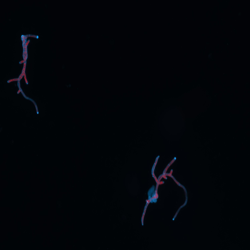

In [22]:
img.resize(size=(250, 250))

In [23]:
out = get_binary_target(masks, labels, ToTensor(), size=(250, 250))
out.shape

torch.Size([1, 1, 250, 250])

(-0.5, 249.5, 249.5, -0.5)

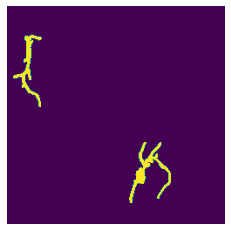

In [24]:
plt.imshow(out.numpy()[0,0,:,:])
plt.axis('off')

In [25]:
# simple test para ver si se agregan las mascaras correctamente en un solo canal
assert (out[0,0,:,:] == torch.where(ToTensor()(Image.open(masks[0]).resize((250, 250))) + ToTensor()(Image.open(masks[1]).resize((250, 250))) > 0.0, 1.0, 0.0)).sum().item() == 250*250, "Todos los pixeles deben ser iguales"

### Collate function y DataLoaders

Sabemos como obtener los _targets_ a partir de las máscaras asociadas a una observación.
Ahora, aplicaremos la transformación a la imagen del input.

Primero, las imágenes como _input_ se le aplican una serie de
transformaciones para adaptarlo al modelo SegFormer. Estas transformaciones
se pueden instanciar con `SegformerFeatureExtractor()`. Toma una imagen
en forma `PIL.Image` y entrega una lista con un array que puede ser
adaptado a numpy, torch, jax, etcétera.

¿Qué pasa con las máscaras?

In [26]:
from transformers import SegformerForSemanticSegmentation, SegformerFeatureExtractor
    
feature_extractor = SegformerFeatureExtractor.from_pretrained("nvidia/mit-b0")
model = SegformerForSemanticSegmentation.from_pretrained("nvidia/mit-b0")

/home/alkzar/.pyenv/versions/3.8.5/envs/eda/lib/python3.8/site-packages/transformers/models/segformer/feature_extraction_segformer.py:28: FutureWarning: The class SegformerFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use SegformerImageProcessor instead.
  warnings.warn(
/home/alkzar/.pyenv/versions/3.8.5/envs/eda/lib/python3.8/site-packages/transformers/models/segformer/image_processing_segformer.py:99: FutureWarning: The `reduce_labels` parameter is deprecated and will be removed in a future version. Please use `do_reduce_labels` instead.
  warnings.warn(
Some weights of the model checkpoint at nvidia/mit-b0 were not used when initializing SegformerForSemanticSegmentation: ['classifier.weight', 'classifier.bias']
- This IS expected if you are initializing SegformerForSemanticSegmentation from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPr

In [27]:
# Create a collate function to strack the masks as channels in the same tensor
def collate_fn(batch, target_fn=get_target):
    """
        Collate function to stack the masks as channels in the same tensor.
        get_target: function to get the target tensor from the masks and labels
            could be multi-labeling or binary.
    """ 
    # Acá se pueden agregar todas las transformacaiones adicionales de preproceso
    # que se requieran para las máscaras. Lo única esencial es pasar una PIL.Image
    # a tensor
    tfms = ToTensor()
    images = torch.cat([feature_extractor(example['image'], return_tensors='pt')['pixel_values'] for example in batch])
    masks = [example['masks'] for example in batch]
    labels = [example['labels'] for example in batch]
    targets = torch.cat([target_fn(x[0], x[1], tfms, size=(512,512)) for x in zip(masks, labels)])

    # transformar a 1 cuando haya un entero distinto a 0 (semantic segmentation)
    targets = torch.where(targets > 0.0, 1.0, 0.0)
    return images, targets

In [28]:
from torch.utils.data import DataLoader

# Create a DataLoader object to stacking each mask as a channel in the same tensor
# and to shuffle the dataset
dataloader = DataLoader(dataset, batch_size=2, shuffle=True, num_workers=0,
                        collate_fn=collate_fn)

xb, yb = next(iter(dataloader))
xb.shape, yb.shape

(torch.Size([2, 3, 512, 512]), torch.Size([2, 4, 512, 512]))

## SegFormer

### Sanity check I: understanding the output models

In [29]:
dataset._id2label[3] = 'non-detection'
dataset._label2id['non-detection'] = 3

In [30]:
set_seed()  # for reproducibility

# initialize model
dataset._id2label[3] = 'non-detection'
dataset._label2id['non-detection'] = 3

model = SegformerForSemanticSegmentation.from_pretrained(
    "nvidia/mit-b0",
    id2label=dataset._id2label,
    label2id=dataset._label2id
)

# model to device
model=model.to(device)

lr = 1e-4 
n_epochs = 1000
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)

xb=xb.to(device)
yb=yb.to(device)
xb.shape, yb.shape

Random seed set as 42313988


Some weights of the model checkpoint at nvidia/mit-b0 were not used when initializing SegformerForSemanticSegmentation: ['classifier.weight', 'classifier.bias']
- This IS expected if you are initializing SegformerForSemanticSegmentation from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing SegformerForSemanticSegmentation from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b0 and are newly initialized: ['decode_head.batch_norm.running_mean', 'decode_head.batch_norm.weight', 'decode_head.linear_c.1.proj.bias', 'decode_head.linear_c.0.proj.bias', 'decode_head.linear_c.1.proj.weight', 'decode_head.batc

(torch.Size([2, 3, 512, 512]), torch.Size([2, 4, 512, 512]))

Analicemos el output que nos entrega un modelo al pasarle un batch con dos ejemplos.

In [31]:
model.eval()
out = model(xb)['logits']
out.shape

torch.Size([2, 4, 128, 128])

Escalamos los logits a la resolución de entrada de la imagen, utilizamos `upscale_logits`.

In [32]:
out = upscale_logits(out)
out.shape

torch.Size([2, 4, 512, 512])

Necesitamos clasificar cada pixel de la imagen en alguna de las 3 clases posibles (+1 que es no detección). Utilizamos una función `softmax(out, dim=1)` en la profundidad de cada pixel para crear una distribución multinomial que nos entregue la probabilidad de que cada pixel pertenezca a la clase 0, 1, 2 y 3.

Esto sería equivalente a `argmax(out, dim=1)` donde `dim=1` es la dimensión donde tenemos nuestras etiquetas.

In [33]:
pred_labels = torch.softmax(out, dim=1).detach().cpu()
pred_labels.shape

torch.Size([2, 4, 512, 512])

Entonces, para el primer pixel las predicciones respecto a los 4 outputs son practicamente uniformes.

In [34]:
pred_labels[0,:,0,0]

tensor([0.2387, 0.2538, 0.2585, 0.2490])

Cómo comparar la predicción de cada pixel usando `nn.CrossEntropyLoss`?

In [35]:
out.shape, yb.shape

(torch.Size([2, 4, 512, 512]), torch.Size([2, 4, 512, 512]))

In [36]:
out.view(2, -1).shape, yb.view(2, -1).shape

(torch.Size([2, 1048576]), torch.Size([2, 1048576]))

In [37]:
loss_fn = nn.CrossEntropyLoss()

model.eval()
loss_fn(
    out,
    torch.argmax(yb, dim=1).to(torch.long)
)

tensor(1.4154, device='cuda:0', grad_fn=<NllLoss2DBackward>)

Utilizar `ignore_index` para ignorar la clase `non-detection` en el calculo de la función de costo.

Ver documentación de [`nn.CrossEntropyLoss`](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html?highlight=crossentropyloss#torch.nn.CrossEntropyLoss).


Computar la función de costo con `nn.CrossEntropyLoss`:

In [38]:
loss_fn = nn.CrossEntropyLoss(ignore_index=3)

loss_fn(
    out,
    torch.argmax(yb, dim=1).to(torch.long)
)

tensor(1.4154, device='cuda:0', grad_fn=<NllLoss2DBackward>)

#### Computar función de costo con single-mask

In [59]:
set_seed()  # for reproducibility

stoi = {'normal': 1, 'non-detection': 0}
itos = {1: 'normal', 0: 'non-detection'}

model = SegformerForSemanticSegmentation.from_pretrained(
    "nvidia/mit-b0",
    id2label=stoi,
    label2id=itos,
)

# model to device
model=model.to(device)

lr = 1e-4 
n_epochs = 300
loss_fn = nn.CrossEntropyLoss(ignore_index=0)
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)

dataloader = DataLoader(dataset, batch_size=2, shuffle=True, num_workers=0,
                        collate_fn = 
                        lambda x: collate_fn(x, target_fn=get_binary_target))

xb, yb = next(iter(dataloader))

xb=xb.to(device)
yb=yb.to(device)
xb.shape, yb.shape

Random seed set as 42313988


Some weights of the model checkpoint at nvidia/mit-b0 were not used when initializing SegformerForSemanticSegmentation: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing SegformerForSemanticSegmentation from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing SegformerForSemanticSegmentation from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b0 and are newly initialized: ['decode_head.linear_c.0.proj.weight', 'decode_head.linear_c.3.proj.weight', 'decode_head.linear_c.0.proj.bias', 'decode_head.batch_norm.bias', 'decode_head.linear_c.1.proj.bias', 'decode_head.linear_

(torch.Size([2, 3, 512, 512]), torch.Size([2, 1, 512, 512]))

In [60]:
model.eval()
out = model(xb)['logits']
out.shape

torch.Size([2, 2, 128, 128])

In [62]:
yb.shape

torch.Size([2, 1, 512, 512])

In [61]:
loss_fn = nn.CrossEntropyLoss(ignore_index=0)

loss_fn(upscale_logits(out),            # (2, 2, 512, 512)
        yb.squeeze(1).to(torch.long)    # (2, 512, 512)
)

tensor(0.6803, device='cuda:0', grad_fn=<NllLoss2DBackward>)

In [72]:
loss_fn(
        upscale_logits(out).view(2, 2, -1),   # (2, 2, 512*512=262144)
        yb.view(2, -1).to(torch.long)         # (2, 512*512=262144)
)

tensor(0.6803, device='cuda:0', grad_fn=<NllLoss2DBackward>)

### Sanity check II: overfit a mini-batch 

In [40]:
set_seed()  # for reproducibility

model = SegformerForSemanticSegmentation.from_pretrained(
    "nvidia/mit-b0",
    id2label=dataset._id2label,
    label2id=dataset._label2id
)

model=model.to(device)

lr = 1e-4 
n_epochs = 600
loss_fn = nn.CrossEntropyLoss(ignore_index=3)
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)

# move tensors into the current device
xb=xb.to(device)
yb=yb.to(device)

Random seed set as 42313988


Some weights of the model checkpoint at nvidia/mit-b0 were not used when initializing SegformerForSemanticSegmentation: ['classifier.weight', 'classifier.bias']
- This IS expected if you are initializing SegformerForSemanticSegmentation from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing SegformerForSemanticSegmentation from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b0 and are newly initialized: ['decode_head.batch_norm.running_mean', 'decode_head.batch_norm.weight', 'decode_head.linear_c.1.proj.bias', 'decode_head.linear_c.0.proj.bias', 'decode_head.linear_c.1.proj.weight', 'decode_head.batc

Predicciones de máscaras con capacidad inicial del modelo.

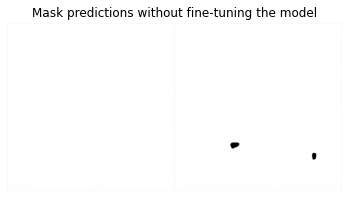

In [42]:
model.eval()

grid=torchvision.utils.make_grid(
    torch.argmax(torch.softmax(upscale_logits(model(xb)["logits"]), dim=1), dim=1).unsqueeze(1).detach().cpu(),
    nrow=2,
    pad_value=8)

plt.imshow(np.uint8(grid.permute(1,2,0).numpy()) * 255);
plt.axis("off");
plt.title(f"Mask predictions without fine-tuning the model");

Memorizar las máscaras del _mini-batch_.

In [44]:
# compute running time
start_time = time.time()

set_seed()  # for reproducibility

# the target will be constant (just one batch)
#target=flatten_logits(torch.where(yb > 0.0, 1.0, 0.0))
lossi=np.zeros(n_epochs)

for idx in tqdm(range(n_epochs)):

  # Perform a forward pass
  logits = model(xb)["logits"]

  # Clean the gradients  
  optimizer.zero_grad()

  # compute the loss with class indices (faster way)
  loss = loss_fn(upscale_logits(logits),
                 torch.argmax(yb, dim=1).to(torch.long))

  #loss = loss_fn(upscale_logits(logits),
  #               yb.squeeze(1).to(torch.long)
  #)

  # store the current loss value
  cur_loss = loss.item()
  lossi[idx] = cur_loss

  # Backward prop
  loss.backward()

  # Update the parameters
  optimizer.step()

  if idx%100== 0:
    print(f" -- Loss at epoch {idx}: {cur_loss:.4f}")

# compute running time
end_time = time.time()
print(f"--- {end_time - start_time} seconds ---")

Random seed set as 42313988


  0%|          | 1/600 [00:00<03:50,  2.59it/s]

 -- Loss at epoch 0: 1.4154


 17%|█▋        | 101/600 [00:37<03:05,  2.69it/s]

 -- Loss at epoch 100: 0.0312


 34%|███▎      | 201/600 [01:14<02:28,  2.68it/s]

 -- Loss at epoch 200: 0.0093


 50%|█████     | 301/600 [01:52<01:51,  2.67it/s]

 -- Loss at epoch 300: 0.0060


 67%|██████▋   | 401/600 [02:29<01:13,  2.69it/s]

 -- Loss at epoch 400: 0.0046


 84%|████████▎ | 501/600 [03:06<00:36,  2.70it/s]

 -- Loss at epoch 500: 0.0045


100%|██████████| 600/600 [03:43<00:00,  2.69it/s]

--- 223.1400125026703 seconds ---


Inspeccionemos la curva de pérdida...

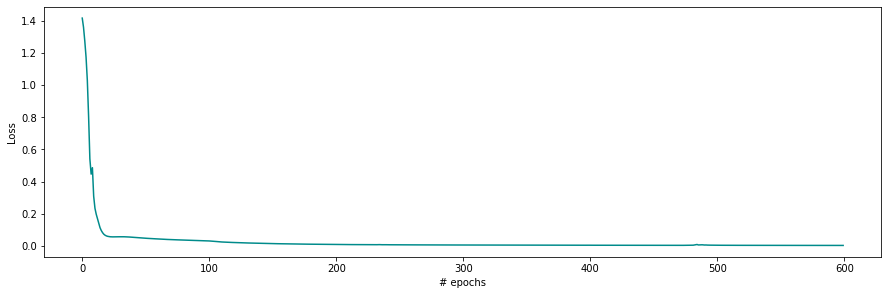

In [45]:
plt.figure(figsize=(15, 4.6));
plt.plot(lossi, color="darkcyan");
plt.xlabel("# epochs");
plt.ylabel("Loss");

Ahora veamos las máscaras luego de memorizarlas.

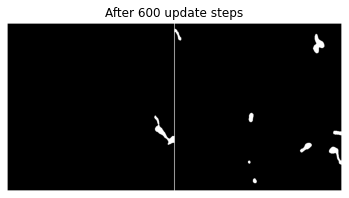

In [46]:
#@title
out=torch.argmax(torch.softmax(upscale_logits(model(xb)["logits"]), dim=1), dim=1).unsqueeze(1).detach().cpu()

grid=torchvision.utils.make_grid(
    out,
    nrow=2,
    pad_value=8)

plt.imshow(np.uint8(grid.permute(1,2,0).numpy()) * 255, cmap='Greys');
plt.axis("off");
plt.title(f"After {n_epochs} update steps");

Comparemos con las autenticas máscaras...

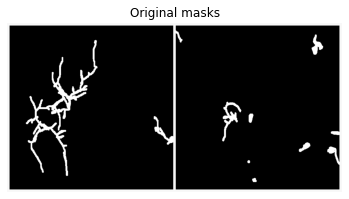

In [47]:
grid=torchvision.utils.make_grid(
    #yb.unsqueeze(1).detach(),
    yb.max(dim=1)[0].unsqueeze(1).detach().cpu(),
    nrow=2,
    padding=8,
    pad_value=8
    )

plt.imshow(np.uint8(grid.permute(1,2,0).cpu().numpy()) * 255)
plt.axis("off");
plt.title("Original masks");

No es perfecto, pero la red no solo propaga la información sino que es
capaz de memorizar algunos máscaras. Antes de probar con más iteraciones o
una mayor tasa de aprendizaje, hay que ver como visualizar las distintas clases.

Lo de arriba es una imagen 1/0 o detección/no-detección. Sin embargo, dentro
de detección tenemos más categorias como `normal`, `normal_cut`, y `noise`.

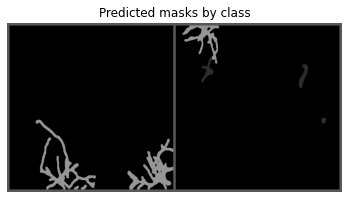

In [68]:
grid = torchvision.utils.make_grid(out.detach().cpu(), nrow=2, padding=8, pad_value=4)

#plt.imshow(np.uint8(grid.permute(1,2,0).numpy() * 120), cmap='viridis');
plt.imshow(np.uint8(grid.permute(1,2,0).numpy() * 150))
plt.axis('off');
plt.title('Predicted masks by class');

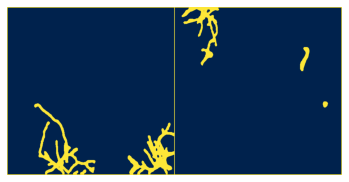

In [69]:
# TODO: cada clase mapearla a un color RGB a partir de un entero de clase a
# una tupla RGB proveniente de una paleta como cividis
viridis = cm.get_cmap('cividis', torch.max(out.detach().cpu()).item()+1)
grid = torchvision.utils.make_grid(out.detach().cpu(), nrow=2, padding=2, 
                                   pad_value=torch.max(out.detach().cpu()).item()+1)
#post_grid = (grid.permute(1,2,0).numpy() * 255).astype('float')
post_grid = (grid.permute(1,2,0).numpy() * 255).astype('float')
# por cada clase remplazar entero a RGB, viridis(integer) -> (R,G,B)
for v in np.unique(post_grid):
    for i in range(post_grid.shape[2]):
        #print(f"viridis({v})[{i}]: {viridis(v)[i]}")
        post_grid[:,:,i] = np.ma.array(post_grid[:,:], 
                                       mask=np.where(post_grid[:,:] == v, 1, 0)).filled(
                                                viridis(v)[i])[:,:,i]
plt.imshow(post_grid);
plt.axis('off');

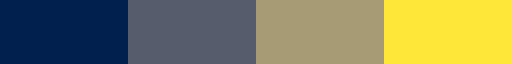

In [70]:
cm.get_cmap('cividis', grid.max()+1)

#### Overfit a single mini-batch with one label

In [8]:
set_seed(42313988)  # for reproducibility

stoi = {'normal': 1, 'non-detection': 0}
itos = {1: 'normal', 0: 'non-detection'}

model = SegformerForSemanticSegmentation.from_pretrained(
    "nvidia/mit-b0",
    id2label=stoi,
    label2id=itos,
)

# model to device
model=model.to(device)

lr = 1e-4 
n_epochs = 10
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)

dataloader = DataLoader(dataset, batch_size=2, shuffle=True, num_workers=0,
                        collate_fn = 
                        lambda x: collate_fn(x, target_fn=get_binary_target))

xb, yb = next(iter(dataloader))

xb=xb.to(device)
yb=yb.to(device)
xb.shape, yb.shape

Random seed set as 42313988


Some weights of the model checkpoint at nvidia/mit-b0 were not used when initializing SegformerForSemanticSegmentation: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing SegformerForSemanticSegmentation from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing SegformerForSemanticSegmentation from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b0 and are newly initialized: ['decode_head.linear_c.3.proj.bias', 'decode_head.batch_norm.bias', 'decode_head.linear_c.2.proj.weight', 'decode_head.classifier.bias', 'decode_head.linear_c.2.proj.bias', 'decode_head.linear_c.1.pro

(torch.Size([2, 3, 512, 512]), torch.Size([2, 1, 512, 512]))

In [9]:
model.eval()

grid=torchvision.utils.make_grid(
    torch.argmax(torch.softmax(upscale_logits(model(xb)["logits"]), dim=1), dim=1).unsqueeze(1).detach().cpu(),
    nrow=2,
    padding=8,
    pad_value=8)

plt.imshow(np.uint8(grid.permute(1,2,0).numpy()) * 255);
plt.axis("off");
plt.title(f"Mask predictions without fine-tuning the model");

RuntimeError: CUDA out of memory. Tried to allocate 1.95 GiB (GPU 0; 3.95 GiB total capacity; 2.75 GiB already allocated; 619.50 MiB free; 2.77 GiB reserved in total by PyTorch)

In [19]:
# compute running time
start_time = time.time()

set_seed()  # for reproducibility

# the target will be constant (just one batch)
#target=flatten_logits(torch.where(yb > 0.0, 1.0, 0.0))
lossi=np.zeros(n_epochs)

for idx in tqdm(range(n_epochs)):

  # Perform a forward pass
  logits = model(xb)["logits"]

  # Clean the gradients  
  optimizer.zero_grad()

  # Compute the loss with class probabilities (slower way)
  #loss = loss_fn(upscale_logits(logits), yb)

  # compute the loss with class indices (faster way)
  #loss = loss_fn(upscale_logits(logits),
  #               torch.argmax(yb, dim=1).to(torch.long))

  loss = loss_fn(upscale_logits(logits),
                 yb.squeeze(1).to(torch.long)
  )

  # store the current loss value
  cur_loss = loss.item()
  lossi[idx] = cur_loss

  # Backward prop
  loss.backward()

  # Update the parameters
  optimizer.step()

  if idx%5== 0:
    print(f" -- Loss at epoch {idx}: {cur_loss:.4f}")

# compute running time
end_time = time.time()
print(f"--- {end_time - start_time} seconds ---")

Random seed set as 42313988


  0%|          | 0/10 [00:00<?, ?it/s]


RuntimeError: CUDA out of memory. Tried to allocate 32.00 MiB (GPU 0; 3.95 GiB total capacity; 3.33 GiB already allocated; 19.50 MiB free; 3.35 GiB reserved in total by PyTorch)

In [16]:
plt.figure(figsize=(15, 4.6));
plt.plot(lossi, color="darkcyan");
plt.xlabel("# epochs");
plt.ylabel("Loss");

NameError: name 'lossi' is not defined

<Figure size 1080x331.2 with 0 Axes>

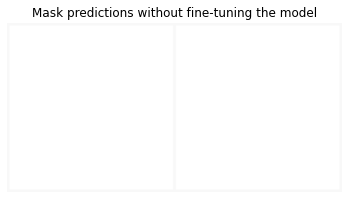

In [117]:
model.eval()

grid=torchvision.utils.make_grid(
    torch.argmax(torch.softmax(upscale_logits(model(xb)["logits"]), dim=1), dim=1).unsqueeze(1).detach().cpu(),
    nrow=2,
    padding=8,
    pad_value=8)

plt.imshow(np.uint8(grid.permute(1,2,0).numpy()) * 255);
plt.axis("off");
plt.title(f"Mask predictions without fine-tuning the model");

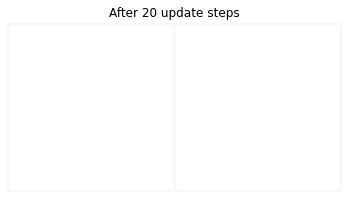

In [102]:
#@title
out=torch.argmax(torch.softmax(upscale_logits(model(xb)["logits"]), dim=1), dim=1).unsqueeze(1).detach().cpu()

grid=torchvision.utils.make_grid(
    out,
    nrow=2,
    padding=8,
    pad_value=8)

plt.imshow(np.uint8(grid.permute(1,2,0).numpy()) * 255, cmap='Greys');
plt.axis("off");
plt.title(f"After {n_epochs} update steps");

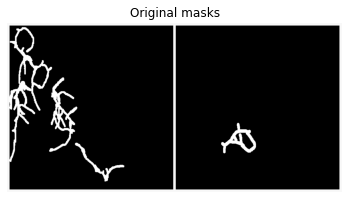

In [24]:
grid=torchvision.utils.make_grid(
    #yb.unsqueeze(1).detach(),
    yb.max(dim=1)[0].unsqueeze(1).detach().cpu(),
    nrow=2,
    padding=8,
    pad_value=8
    )

plt.imshow(np.uint8(grid.permute(1,2,0).cpu().numpy()) * 255)
plt.axis("off");
plt.title("Original masks");

### Sanity Check III: compute Intersection Over Union (mIoU) metric

La intersección sobre la unión de dos conjuntos A y B es una métrica que va de $0\leq J(A, B) \leq 1$.

Esta métrica de similitud entre dos conjuntos, `preds` y `targets` en  este caso particular, se conoce también como [_Jaccard index_](https://en.wikipedia.org/wiki/Jaccard_index).

Más sobre las métricas utilizadas para este _task_, ver página 380,
sección Precision vs. recall del libro [Computer Vision: Algorithms and Applications](http://szeliski.org/Book/).

In [71]:
model.eval()
logits = model(xb)["logits"]
target = yb

In [72]:
logits.shape, target.shape

(torch.Size([2, 4, 128, 128]), torch.Size([2, 4, 512, 512]))

In [73]:
preds = upscale_logits(logits.detach().cpu())
target_c = torch.argmax(target.detach().cpu(), dim=1)
# normalize the logits and get probabilities
preds = torch.argmax(torch.softmax(preds, dim=1), dim=1)

In [74]:
preds.shape, target_c.shape

(torch.Size([2, 512, 512]), torch.Size([2, 512, 512]))

In [75]:
eps=1e-6
intersection = torch.logical_and(preds, target_c)
union = torch.logical_or(preds, target_c)
iou = (torch.div(torch.sum(intersection, dim=(1,2)) + eps, (torch.sum(union, dim=(1,2)) + eps)).sum() / logits.shape[0]).item()
iou

0.930385410785675

Ahora creamos una función que reciba los logits extraídos del modelo
y los targets de cada _batch_.

In [23]:
def compute_intersection_over_union(logits, targets, eps=1e-6):
    """ 
    Compute the intersection over union between the logits and the targets

    B: batch size
    C: number of classes
    H: height of the image
    W: width of the image

    Args:
        logits: torch.tensor with shape (B, C, H, W) containing the logits 
            return by the model
        targets: torch.tensor with shape (B, C, H, W) containing the targets
            return by the DataLoader format

    Returns: a float with the ratio of intersection over union
    """
    # eliminar grafo de gradiente y pasar a cpu
    preds = upscale_logits(logits.detach().cpu())
    targets = targets.detach().cpu()

    # normalizar logits y obtener probabilidades
    preds = torch.argmax(torch.softmax(preds, dim=1), dim=1)

    # colapsar los canales del target en uno solo, de multiples one-hot channels
    # a un solo canal con valores enteros
    targets = torch.argmax(targets, dim=1)

    # computar intersección y unión entre conjuntos de prediccion y targets
    intersection = torch.logical_and(preds, targets)
    union = torch.logical_or(preds, targets)

    # computar ratio de intersección sobre la unión 
    iou = (torch.div(torch.sum(intersection, dim=(1,2)) + eps, 
                     (torch.sum(union, dim=(1,2)) + eps)).sum() / logits.shape[0]).item()

    return iou

In [77]:
compute_intersection_over_union(logits, target)

0.930385410785675

## Training the model

Configuración y dínamica básica de entrenamiento del modelo.


**TODO:** 

* during training all predictions with $\text{IoU} > \tau$ with a ground truth, are matched to the ground truth (check slide 86 [here](https://drive.google.com/file/d/1tL4N6Xg4h4IjGR8UCfvUWFZ8OUHIwlOO/view))
* Freeze the backbone like ~3-5 epochs to warm the classification head, then unfreeze and train with a lower learning rate than the classification head

In [29]:
#from evaluation import compute_intersection_over_union
from utils import flatten_logits, upscale_logits
from contextlib import nullcontext
from torch.cuda.amp import GradScaler, autocast

set_seed()  # for reproducibility

model = SegformerForSemanticSegmentation.from_pretrained(
    "nvidia/mit-b0",
    id2label=dataset._id2label,
    label2id=dataset._label2id
)

model=model.to(device)

n_epochs = 100
lr = 0.03
beta1 = 0.9
beta2 = 0.95 
bs=2
gradient_accumulation_steps = bs * 4 # bs * 1 = normal, bs * 16 = emulate batch size of 32
dtype = 'float16' # 'float32' or 'float16'
weight_decay = 1e-1
grad_clip = 1.0
scheduler__gamma=0.9
scheduler__step_size=5

torch.backends.cuda.matmul.allow_tf32 = True    # allow tf32 on matmul
torch.backends.cudnn.allow_tf32 = True      # allow tf32 on cudnn
ptdtype={'float32': torch.float32, 'float16': torch.float16, 'bfloat16': torch.bfloat16}[dtype]
ctx = nullcontext() if device=='cpu' else torch.amp.autocast(device_type=device, dtype=ptdtype)
#loss_fn = nn.CrossEntropyLoss(
#                              #weight=weight_classes, 
#                              ignore_index=dataset._label2id['non-detection'])

loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.AdamW(model.parameters(), lr=lr, betas=(beta1, beta2),
                              weight_decay=weight_decay)

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=scheduler__step_size, 
                                            gamma=scheduler__gamma, verbose=False)
scaler = GradScaler()

train_dl = DataLoader(dataset, batch_size=bs, shuffle=True, num_workers=0,
                        collate_fn=collate_fn)

Random seed set as 42313988


Some weights of the model checkpoint at nvidia/mit-b0 were not used when initializing SegformerForSemanticSegmentation: ['classifier.weight', 'classifier.bias']
- This IS expected if you are initializing SegformerForSemanticSegmentation from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing SegformerForSemanticSegmentation from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b0 and are newly initialized: ['decode_head.linear_fuse.weight', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.batch_norm.running_var', 'decode_head.linear_c.0.proj.bias', 'decode_head.linear_c.3.proj.weight', 'decode

In [39]:
# freeze all the parameters except the classification head
for name, params in model.named_parameters():
    if name in ['decode_head.classifier.weight', 'decode_head.classifier.bias']:
        params.requires_grad = True
    else:
        params.requires_grad = False

In [40]:
# compute running time
start_time = time.time()
set_seed()  # for reproducibility
lossi=np.zeros(n_epochs)
iou=np.zeros(n_epochs)

for idx in tqdm(range(n_epochs), ncols=80, leave=True):
  cur_loss=0.0 
  cur_iou = []
  num_batches= 0
  for i, batch in tqdm(enumerate(train_dl), ncols=80, leave=False):
    xb = batch[0].to(device)
    yb = batch[1].to(device)

    with ctx:
      # Perform a forward pass
      logits = model(xb)["logits"]

      # Compute the loss
      loss = loss_fn(upscale_logits(logits),
                     torch.argmax(yb, dim=1).to(torch.long))

      # normalize the loss with regards the number of graddient_accumulation_steps 
      loss = loss / gradient_accumulation_steps

    # Backward prop
    #loss.backward()
    scaler.scale(loss).backward()

    # Update the parameters every once we complete gradient_accumulation_steps or
    # at the last batch in the dataloadaer
    if ((i + 1) % gradient_accumulation_steps == 0) or ((i + 1) == len(train_dl)):
      # clip the gradient
      if grad_clip != 0.0:
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)

      # Scales loss. Calls backward() on scaled loss to create scaled gradients.
      scaler.step(optimizer)
      scaler.update()
      # flush the gradients as soon as we can, no need for this memory anymore
      optimizer.zero_grad(set_to_none=True)
      scheduler.step()

      # update the scale for the next iteration

    # store the current loss value, IoU, and increment the number of batches
    cur_loss += loss.item()
    # require to pass the logits and yb from half to float32 using .float()
    # See: https://pytorch.org/docs/stable/amp.html#autocasting
    cur_iou.append(compute_intersection_over_union(logits.float(), yb.float()))
    num_batches += 1

  lossi[idx] = cur_loss / num_batches
  iou[idx] = np.mean(cur_iou)
  print(f" -- Loss at epoch {idx}: {lossi[idx]:.4f}")
  print(f" -- mIoU at epoch {idx}: {iou[idx]:.4f}")

# compute running time
end_time = time.time()
print(f"--- {end_time - start_time} seconds ---")

Random seed set as 42313988


  1%|▍                                        | 1/100 [00:55<1:32:10, 55.87s/it]

 -- Loss at epoch 0: 0.0834
 -- mIoU at epoch 0: 0.0470


  2%|▊                                        | 2/100 [01:25<1:05:37, 40.18s/it]

 -- Loss at epoch 1: 0.0307
 -- mIoU at epoch 1: 0.0571


  3%|█▎                                         | 3/100 [01:56<58:08, 35.96s/it]

 -- Loss at epoch 2: 0.0248
 -- mIoU at epoch 2: 0.0571


  4%|█▋                                         | 4/100 [02:23<52:09, 32.60s/it]

 -- Loss at epoch 3: 0.0243
 -- mIoU at epoch 3: 0.0571


  5%|██▏                                        | 5/100 [02:50<48:31, 30.65s/it]

 -- Loss at epoch 4: 0.0223
 -- mIoU at epoch 4: 0.0571


  6%|██▌                                        | 6/100 [03:18<46:33, 29.72s/it]

 -- Loss at epoch 5: 0.0199
 -- mIoU at epoch 5: 0.0571


  7%|███                                        | 7/100 [03:47<45:31, 29.37s/it]

 -- Loss at epoch 6: 0.0174
 -- mIoU at epoch 6: 0.0571


  8%|███▍                                       | 8/100 [04:14<44:01, 28.71s/it]

 -- Loss at epoch 7: 0.0150
 -- mIoU at epoch 7: 0.0571


  9%|███▊                                       | 9/100 [04:41<42:50, 28.25s/it]

 -- Loss at epoch 8: 0.0129
 -- mIoU at epoch 8: 0.0586


 10%|████▏                                     | 10/100 [05:09<42:20, 28.23s/it]

 -- Loss at epoch 9: 0.0118
 -- mIoU at epoch 9: 0.0801


 11%|████▌                                     | 11/100 [05:39<42:31, 28.67s/it]

 -- Loss at epoch 10: 0.0121
 -- mIoU at epoch 10: 0.0697


 12%|█████                                     | 12/100 [06:09<42:22, 28.90s/it]

 -- Loss at epoch 11: 0.0113
 -- mIoU at epoch 11: 0.0617


 13%|█████▍                                    | 13/100 [06:38<41:59, 28.95s/it]

 -- Loss at epoch 12: 0.0110
 -- mIoU at epoch 12: 0.0711


 14%|█████▉                                    | 14/100 [07:06<41:28, 28.93s/it]

 -- Loss at epoch 13: 0.0107
 -- mIoU at epoch 13: 0.0624


 15%|██████▎                                   | 15/100 [07:36<41:07, 29.03s/it]

 -- Loss at epoch 14: 0.0105
 -- mIoU at epoch 14: 0.0673


 16%|██████▋                                   | 16/100 [08:06<41:01, 29.30s/it]

 -- Loss at epoch 15: 0.0104
 -- mIoU at epoch 15: 0.0785


 17%|███████▏                                  | 17/100 [08:35<40:24, 29.21s/it]

 -- Loss at epoch 16: 0.0102
 -- mIoU at epoch 16: 0.0881


 18%|███████▌                                  | 18/100 [09:02<39:09, 28.65s/it]

 -- Loss at epoch 17: 0.0102
 -- mIoU at epoch 17: 0.0880


 19%|███████▉                                  | 19/100 [09:30<38:19, 28.39s/it]

 -- Loss at epoch 18: 0.0098
 -- mIoU at epoch 18: 0.0874


 20%|████████▍                                 | 20/100 [09:57<37:28, 28.10s/it]

 -- Loss at epoch 19: 0.0096
 -- mIoU at epoch 19: 0.0999


 21%|████████▊                                 | 21/100 [10:25<36:42, 27.89s/it]

 -- Loss at epoch 20: 0.0096
 -- mIoU at epoch 20: 0.0829


 22%|█████████▏                                | 22/100 [10:53<36:18, 27.93s/it]

 -- Loss at epoch 21: 0.0095
 -- mIoU at epoch 21: 0.0827


 23%|█████████▋                                | 23/100 [11:20<35:26, 27.62s/it]

 -- Loss at epoch 22: 0.0093
 -- mIoU at epoch 22: 0.0845


 24%|██████████                                | 24/100 [11:47<34:47, 27.46s/it]

 -- Loss at epoch 23: 0.0093
 -- mIoU at epoch 23: 0.0869


 25%|██████████▌                               | 25/100 [12:13<33:58, 27.18s/it]

 -- Loss at epoch 24: 0.0090
 -- mIoU at epoch 24: 0.1022


 26%|██████████▉                               | 26/100 [12:40<33:15, 26.97s/it]

 -- Loss at epoch 25: 0.0090
 -- mIoU at epoch 25: 0.0883


 27%|███████████▎                              | 27/100 [13:06<32:46, 26.94s/it]

 -- Loss at epoch 26: 0.0092
 -- mIoU at epoch 26: 0.0895


 28%|███████████▊                              | 28/100 [13:33<32:10, 26.81s/it]

 -- Loss at epoch 27: 0.0089
 -- mIoU at epoch 27: 0.0872


 29%|████████████▏                             | 29/100 [14:00<31:45, 26.83s/it]

 -- Loss at epoch 28: 0.0088
 -- mIoU at epoch 28: 0.0867


 30%|████████████▌                             | 30/100 [14:26<31:09, 26.71s/it]

 -- Loss at epoch 29: 0.0090
 -- mIoU at epoch 29: 0.0882


 31%|█████████████                             | 31/100 [14:53<30:40, 26.67s/it]

 -- Loss at epoch 30: 0.0087
 -- mIoU at epoch 30: 0.0866


 32%|█████████████▍                            | 32/100 [15:20<30:12, 26.66s/it]

 -- Loss at epoch 31: 0.0088
 -- mIoU at epoch 31: 0.0875


 33%|█████████████▊                            | 33/100 [15:46<29:41, 26.58s/it]

 -- Loss at epoch 32: 0.0086
 -- mIoU at epoch 32: 0.0879


 34%|██████████████▎                           | 34/100 [16:12<29:12, 26.56s/it]

 -- Loss at epoch 33: 0.0086
 -- mIoU at epoch 33: 0.0885


 35%|██████████████▋                           | 35/100 [16:39<28:51, 26.63s/it]

 -- Loss at epoch 34: 0.0085
 -- mIoU at epoch 34: 0.0885


 36%|███████████████                           | 36/100 [17:03<27:33, 25.83s/it]

 -- Loss at epoch 35: 0.0084
 -- mIoU at epoch 35: 0.0884


 37%|███████████████▌                          | 37/100 [17:26<26:13, 24.97s/it]

 -- Loss at epoch 36: 0.0087
 -- mIoU at epoch 36: 0.0887


 38%|███████████████▉                          | 38/100 [17:49<25:12, 24.39s/it]

 -- Loss at epoch 37: 0.0086
 -- mIoU at epoch 37: 0.0886


 39%|████████████████▍                         | 39/100 [18:12<24:24, 24.01s/it]

 -- Loss at epoch 38: 0.0085
 -- mIoU at epoch 38: 0.0888


 40%|████████████████▊                         | 40/100 [18:35<23:42, 23.70s/it]

 -- Loss at epoch 39: 0.0084
 -- mIoU at epoch 39: 0.0891


 41%|█████████████████▏                        | 41/100 [18:58<23:06, 23.50s/it]

 -- Loss at epoch 40: 0.0084
 -- mIoU at epoch 40: 0.0888


 42%|█████████████████▋                        | 42/100 [19:21<22:35, 23.37s/it]

 -- Loss at epoch 41: 0.0083
 -- mIoU at epoch 41: 0.0888


 43%|██████████████████                        | 43/100 [19:44<22:06, 23.27s/it]

 -- Loss at epoch 42: 0.0083
 -- mIoU at epoch 42: 0.0954


 44%|██████████████████▍                       | 44/100 [20:07<21:37, 23.17s/it]

 -- Loss at epoch 43: 0.0083
 -- mIoU at epoch 43: 0.0887


 45%|██████████████████▉                       | 45/100 [20:30<21:10, 23.10s/it]

 -- Loss at epoch 44: 0.0083
 -- mIoU at epoch 44: 0.0888


 46%|███████████████████▎                      | 46/100 [20:53<20:44, 23.05s/it]

 -- Loss at epoch 45: 0.0083
 -- mIoU at epoch 45: 0.0889


 47%|███████████████████▋                      | 47/100 [21:16<20:23, 23.08s/it]

 -- Loss at epoch 46: 0.0084
 -- mIoU at epoch 46: 0.0917


 48%|████████████████████▏                     | 48/100 [21:39<19:56, 23.01s/it]

 -- Loss at epoch 47: 0.0084
 -- mIoU at epoch 47: 0.0889


 49%|████████████████████▌                     | 49/100 [22:02<19:31, 22.98s/it]

 -- Loss at epoch 48: 0.0084
 -- mIoU at epoch 48: 0.0890


 50%|█████████████████████                     | 50/100 [22:25<19:07, 22.96s/it]

 -- Loss at epoch 49: 0.0082
 -- mIoU at epoch 49: 0.0956


 51%|█████████████████████▍                    | 51/100 [22:48<18:43, 22.92s/it]

 -- Loss at epoch 50: 0.0084
 -- mIoU at epoch 50: 0.0891


 52%|█████████████████████▊                    | 52/100 [23:11<18:21, 22.95s/it]

 -- Loss at epoch 51: 0.0082
 -- mIoU at epoch 51: 0.0891


 53%|██████████████████████▎                   | 53/100 [23:34<18:00, 22.99s/it]

 -- Loss at epoch 52: 0.0083
 -- mIoU at epoch 52: 0.0891


 54%|██████████████████████▋                   | 54/100 [23:57<17:37, 22.98s/it]

 -- Loss at epoch 53: 0.0083
 -- mIoU at epoch 53: 0.0892


 55%|███████████████████████                   | 55/100 [24:20<17:12, 22.94s/it]

 -- Loss at epoch 54: 0.0084
 -- mIoU at epoch 54: 0.0893


 56%|███████████████████████▌                  | 56/100 [24:43<16:49, 22.95s/it]

 -- Loss at epoch 55: 0.0083
 -- mIoU at epoch 55: 0.0899


 57%|███████████████████████▉                  | 57/100 [25:06<16:26, 22.94s/it]

 -- Loss at epoch 56: 0.0083
 -- mIoU at epoch 56: 0.0892


 58%|████████████████████████▎                 | 58/100 [25:29<16:05, 22.98s/it]

 -- Loss at epoch 57: 0.0084
 -- mIoU at epoch 57: 0.0896


 59%|████████████████████████▊                 | 59/100 [25:52<15:41, 22.97s/it]

 -- Loss at epoch 58: 0.0083
 -- mIoU at epoch 58: 0.0894


 60%|█████████████████████████▏                | 60/100 [26:15<15:20, 23.02s/it]

 -- Loss at epoch 59: 0.0083
 -- mIoU at epoch 59: 0.0905


 61%|█████████████████████████▌                | 61/100 [26:38<14:58, 23.05s/it]

 -- Loss at epoch 60: 0.0082
 -- mIoU at epoch 60: 0.0960


 62%|██████████████████████████                | 62/100 [27:01<14:35, 23.05s/it]

 -- Loss at epoch 61: 0.0083
 -- mIoU at epoch 61: 0.0894


 63%|██████████████████████████▍               | 63/100 [27:24<14:12, 23.03s/it]

 -- Loss at epoch 62: 0.0083
 -- mIoU at epoch 62: 0.0894


 64%|██████████████████████████▉               | 64/100 [27:47<13:48, 23.02s/it]

 -- Loss at epoch 63: 0.0082
 -- mIoU at epoch 63: 0.0894


 65%|███████████████████████████▎              | 65/100 [28:10<13:25, 23.00s/it]

 -- Loss at epoch 64: 0.0083
 -- mIoU at epoch 64: 0.0894


 66%|███████████████████████████▋              | 66/100 [28:33<13:00, 22.97s/it]

 -- Loss at epoch 65: 0.0084
 -- mIoU at epoch 65: 0.0894


 67%|████████████████████████████▏             | 67/100 [28:56<12:39, 23.00s/it]

 -- Loss at epoch 66: 0.0083
 -- mIoU at epoch 66: 0.0894


 68%|████████████████████████████▌             | 68/100 [29:19<12:15, 22.99s/it]

 -- Loss at epoch 67: 0.0083
 -- mIoU at epoch 67: 0.0894


 69%|████████████████████████████▉             | 69/100 [29:42<11:51, 22.96s/it]

 -- Loss at epoch 68: 0.0084
 -- mIoU at epoch 68: 0.0925


 70%|█████████████████████████████▍            | 70/100 [30:05<11:29, 23.00s/it]

 -- Loss at epoch 69: 0.0082
 -- mIoU at epoch 69: 0.0894


 71%|█████████████████████████████▊            | 71/100 [30:28<11:08, 23.04s/it]

 -- Loss at epoch 70: 0.0086
 -- mIoU at epoch 70: 0.0935


 72%|██████████████████████████████▏           | 72/100 [30:51<10:44, 23.02s/it]

 -- Loss at epoch 71: 0.0082
 -- mIoU at epoch 71: 0.0895


 73%|██████████████████████████████▋           | 73/100 [31:14<10:19, 22.96s/it]

 -- Loss at epoch 72: 0.0082
 -- mIoU at epoch 72: 0.0916


 74%|███████████████████████████████           | 74/100 [31:37<09:57, 22.99s/it]

 -- Loss at epoch 73: 0.0083
 -- mIoU at epoch 73: 0.0895


 75%|███████████████████████████████▌          | 75/100 [32:00<09:35, 23.02s/it]

 -- Loss at epoch 74: 0.0084
 -- mIoU at epoch 74: 0.0895


 76%|███████████████████████████████▉          | 76/100 [32:23<09:12, 23.02s/it]

 -- Loss at epoch 75: 0.0084
 -- mIoU at epoch 75: 0.0898


 77%|████████████████████████████████▎         | 77/100 [32:46<08:49, 23.03s/it]

 -- Loss at epoch 76: 0.0084
 -- mIoU at epoch 76: 0.0895


 78%|████████████████████████████████▊         | 78/100 [33:09<08:26, 23.03s/it]

 -- Loss at epoch 77: 0.0082
 -- mIoU at epoch 77: 0.0895


 79%|█████████████████████████████████▏        | 79/100 [33:32<08:03, 23.05s/it]

 -- Loss at epoch 78: 0.0083
 -- mIoU at epoch 78: 0.0895


 80%|█████████████████████████████████▌        | 80/100 [33:55<07:41, 23.07s/it]

 -- Loss at epoch 79: 0.0083
 -- mIoU at epoch 79: 0.0923


 81%|██████████████████████████████████        | 81/100 [34:21<07:31, 23.74s/it]

 -- Loss at epoch 80: 0.0082
 -- mIoU at epoch 80: 0.0895


 82%|██████████████████████████████████▍       | 82/100 [34:44<07:04, 23.58s/it]

 -- Loss at epoch 81: 0.0082
 -- mIoU at epoch 81: 0.0895


 83%|██████████████████████████████████▊       | 83/100 [35:07<06:38, 23.42s/it]

 -- Loss at epoch 82: 0.0082
 -- mIoU at epoch 82: 0.1038


 84%|███████████████████████████████████▎      | 84/100 [35:30<06:12, 23.30s/it]

 -- Loss at epoch 83: 0.0084
 -- mIoU at epoch 83: 0.0898


 85%|███████████████████████████████████▋      | 85/100 [35:53<05:47, 23.17s/it]

 -- Loss at epoch 84: 0.0082
 -- mIoU at epoch 84: 0.0895


 86%|████████████████████████████████████      | 86/100 [36:16<05:23, 23.11s/it]

 -- Loss at epoch 85: 0.0082
 -- mIoU at epoch 85: 0.0895


 87%|████████████████████████████████████▌     | 87/100 [36:39<04:59, 23.05s/it]

 -- Loss at epoch 86: 0.0082
 -- mIoU at epoch 86: 0.1038


 88%|████████████████████████████████████▉     | 88/100 [37:01<04:35, 23.00s/it]

 -- Loss at epoch 87: 0.0083
 -- mIoU at epoch 87: 0.0895


 89%|█████████████████████████████████████▍    | 89/100 [37:24<04:12, 22.97s/it]

 -- Loss at epoch 88: 0.0082
 -- mIoU at epoch 88: 0.0895


 90%|█████████████████████████████████████▊    | 90/100 [37:47<03:49, 22.93s/it]

 -- Loss at epoch 89: 0.0083
 -- mIoU at epoch 89: 0.0924


 91%|██████████████████████████████████████▏   | 91/100 [38:10<03:26, 22.97s/it]

 -- Loss at epoch 90: 0.0083
 -- mIoU at epoch 90: 0.0906


 92%|██████████████████████████████████████▋   | 92/100 [38:33<03:03, 22.98s/it]

 -- Loss at epoch 91: 0.0083
 -- mIoU at epoch 91: 0.0895


 93%|███████████████████████████████████████   | 93/100 [38:56<02:40, 22.96s/it]

 -- Loss at epoch 92: 0.0083
 -- mIoU at epoch 92: 0.0895


 94%|███████████████████████████████████████▍  | 94/100 [39:19<02:17, 22.96s/it]

 -- Loss at epoch 93: 0.0084
 -- mIoU at epoch 93: 0.0898


 95%|███████████████████████████████████████▉  | 95/100 [39:42<01:55, 23.00s/it]

 -- Loss at epoch 94: 0.0082
 -- mIoU at epoch 94: 0.0895


 96%|████████████████████████████████████████▎ | 96/100 [40:05<01:31, 23.00s/it]

 -- Loss at epoch 95: 0.0082
 -- mIoU at epoch 95: 0.0895


 97%|████████████████████████████████████████▋ | 97/100 [40:28<01:09, 23.01s/it]

 -- Loss at epoch 96: 0.0082
 -- mIoU at epoch 96: 0.0895


 98%|█████████████████████████████████████████▏| 98/100 [40:51<00:45, 22.96s/it]

 -- Loss at epoch 97: 0.0082
 -- mIoU at epoch 97: 0.0939


 99%|█████████████████████████████████████████▌| 99/100 [41:14<00:22, 22.95s/it]

 -- Loss at epoch 98: 0.0082
 -- mIoU at epoch 98: 0.0895


100%|█████████████████████████████████████████| 100/100 [41:37<00:00, 24.97s/it]

 -- Loss at epoch 99: 0.0083
 -- mIoU at epoch 99: 0.0899
--- 2497.665179014206 seconds ---


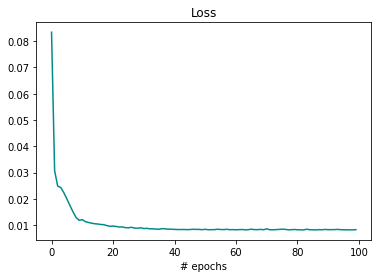

In [41]:
plt.plot(lossi, color='darkcyan');
plt.title('Loss');
plt.xlabel('# epochs');

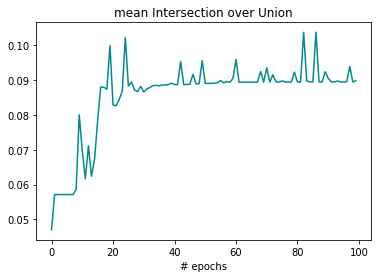

In [42]:
plt.plot(iou, color='darkcyan');
plt.title('mean Intersection over Union');
plt.xlabel('# epochs');

torch.Size([2, 1, 512, 512])
torch.Size([3, 528, 1048])


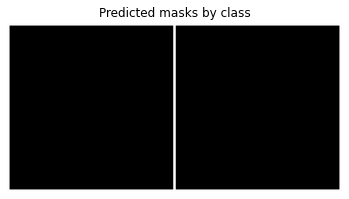

In [43]:
xb, yb = next(iter(train_dl))
xb = xb.to(device)
yb = yb.to(device)

model.eval()
out = model(xb)["logits"]
out = torch.argmax(torch.softmax(upscale_logits(out), dim=1), dim=1, keepdim=True).cpu()
print(out.shape)
grid = torchvision.utils.make_grid(out, nrow=2, padding=8, pad_value=4)
print(grid.shape)
plt.imshow(np.uint8(grid.permute(1,2,0).numpy() * 255), cmap='viridis')
plt.axis('off');
plt.title('Predicted masks by class');

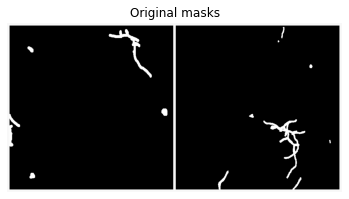

In [44]:
grid=torchvision.utils.make_grid(
    #yb.unsqueeze(1).detach(),
    yb.max(dim=1)[0].unsqueeze(1).detach().cpu(),
    nrow=2,
    padding=8,
    pad_value=8
    )

plt.imshow(np.uint8(grid.permute(1,2,0).cpu().numpy()) * 255)
plt.axis("off");
plt.title("Original masks");

##

## PlantDataset - Dead batch 

In [3]:
from dataset import PlantDataset, extract_ids_from_name

# create a dataset with the test images
label2id = {'dead': 0, 'dead_cut': 1, 'noise': 2}
dead_dataset = PlantDataset('data', 'dead', 'data_inventary.csv', label2id=label2id)

In [4]:
dead_dataset[4]

{'image': <PIL.Image.Image image mode=RGB size=1677x1271>,
 'masks': ['data/dead/original_labeled/5/task-5-annotation-23-by-1-tag-noise-2.png',
  'data/dead/original_labeled/5/task-5-annotation-23-by-1-tag-dead-4.png',
  'data/dead/original_labeled/5/task-5-annotation-23-by-1-tag-noise-1.png',
  'data/dead/original_labeled/5/task-5-annotation-23-by-1-tag-dead-5.png',
  'data/dead/original_labeled/5/task-5-annotation-23-by-1-tag-dead-0.png',
  'data/dead/original_labeled/5/task-5-annotation-23-by-1-tag-dead-2.png',
  'data/dead/original_labeled/5/task-5-annotation-23-by-1-tag-dead_cut-1.png',
  'data/dead/original_labeled/5/task-5-annotation-23-by-1-tag-dead-1.png',
  'data/dead/original_labeled/5/task-5-annotation-23-by-1-tag-noise-3.png',
  'data/dead/original_labeled/5/task-5-annotation-23-by-1-tag-dead-3.png',
  'data/dead/original_labeled/5/task-5-annotation-23-by-1-tag-dead_cut-0.png',
  'data/dead/original_labeled/5/task-5-annotation-23-by-1-tag-noise-0.png'],
 'labels': [2, 0, 2

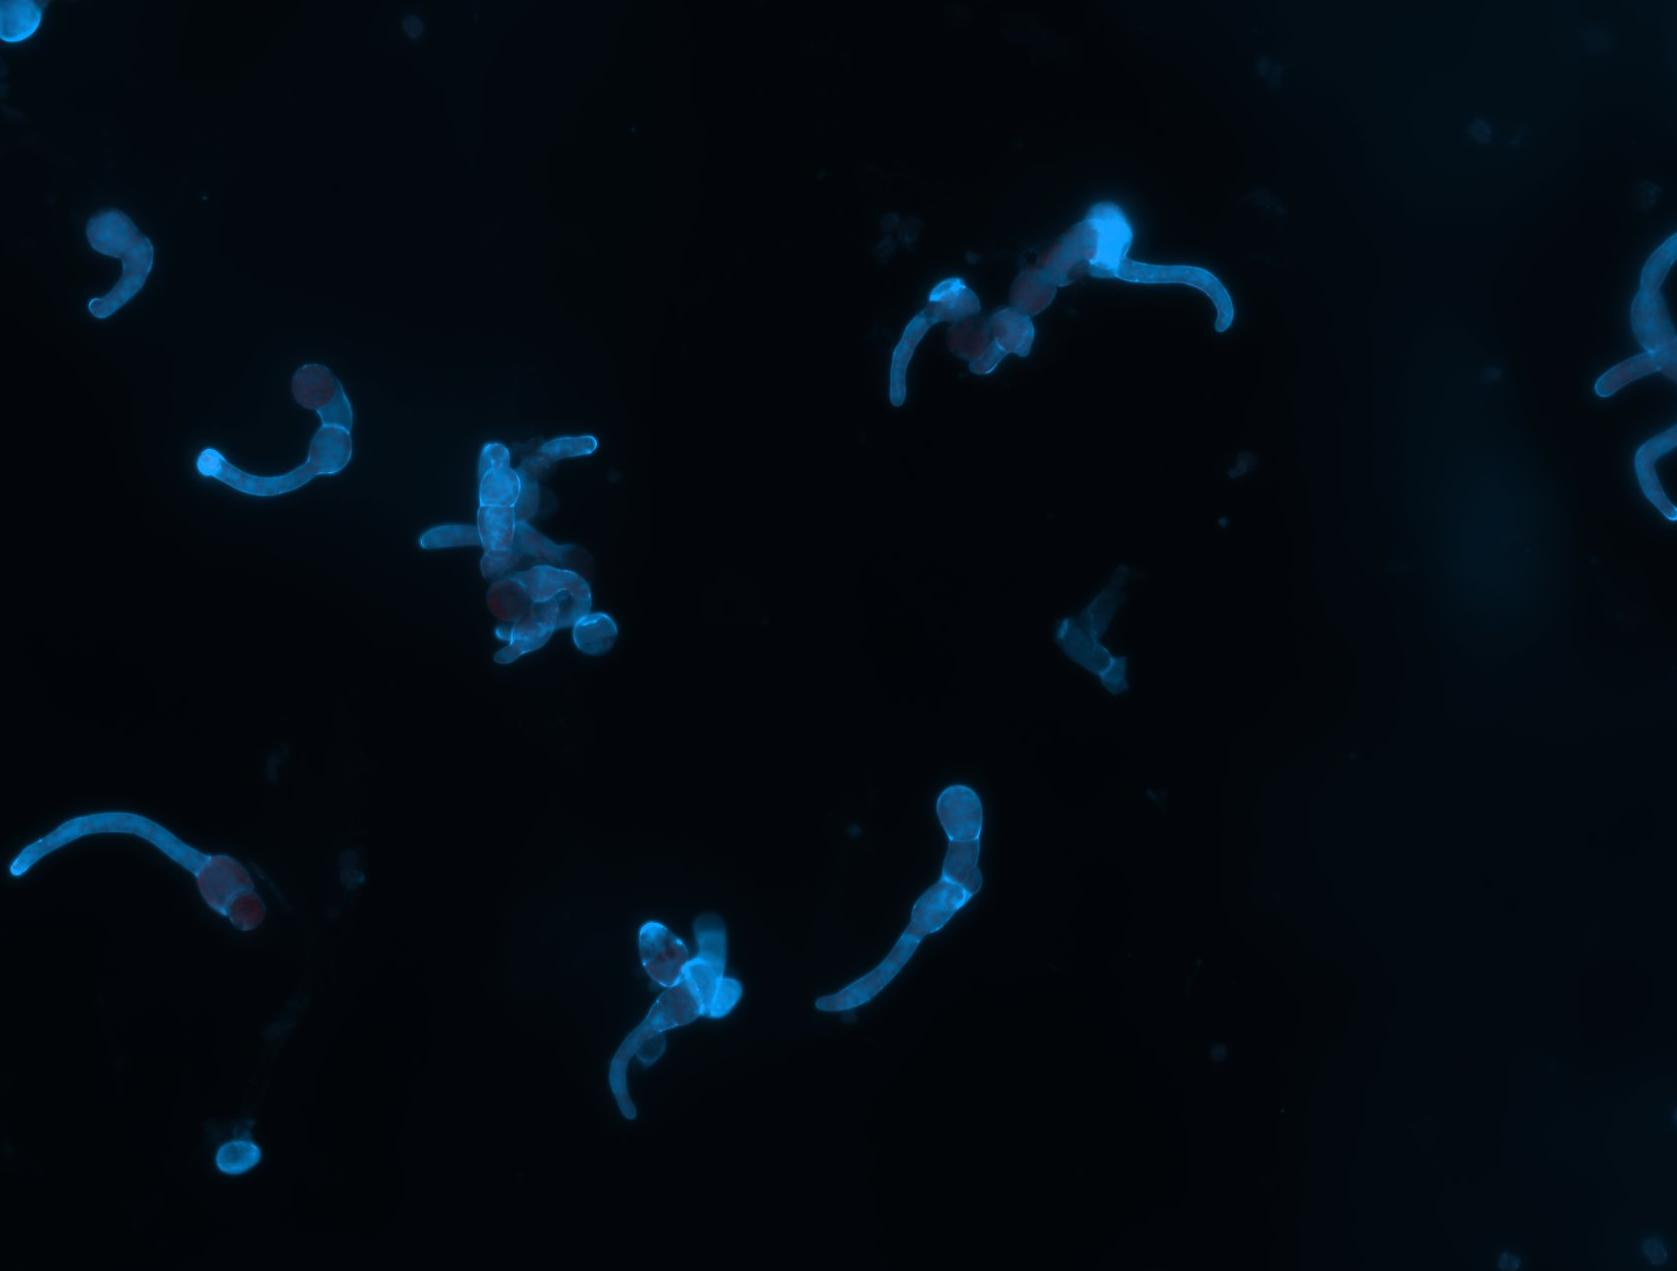

In [5]:
dead_dataset[4]['image']

In [6]:
print(dead_dataset._id2label)
dead_dataset[4]

{0: 'dead', 1: 'dead_cut', 2: 'noise'}


{'image': <PIL.Image.Image image mode=RGB size=1677x1271>,
 'masks': ['data/dead/original_labeled/5/task-5-annotation-23-by-1-tag-noise-2.png',
  'data/dead/original_labeled/5/task-5-annotation-23-by-1-tag-dead-4.png',
  'data/dead/original_labeled/5/task-5-annotation-23-by-1-tag-noise-1.png',
  'data/dead/original_labeled/5/task-5-annotation-23-by-1-tag-dead-5.png',
  'data/dead/original_labeled/5/task-5-annotation-23-by-1-tag-dead-0.png',
  'data/dead/original_labeled/5/task-5-annotation-23-by-1-tag-dead-2.png',
  'data/dead/original_labeled/5/task-5-annotation-23-by-1-tag-dead_cut-1.png',
  'data/dead/original_labeled/5/task-5-annotation-23-by-1-tag-dead-1.png',
  'data/dead/original_labeled/5/task-5-annotation-23-by-1-tag-noise-3.png',
  'data/dead/original_labeled/5/task-5-annotation-23-by-1-tag-dead-3.png',
  'data/dead/original_labeled/5/task-5-annotation-23-by-1-tag-dead_cut-0.png',
  'data/dead/original_labeled/5/task-5-annotation-23-by-1-tag-noise-0.png'],
 'labels': [2, 0, 2

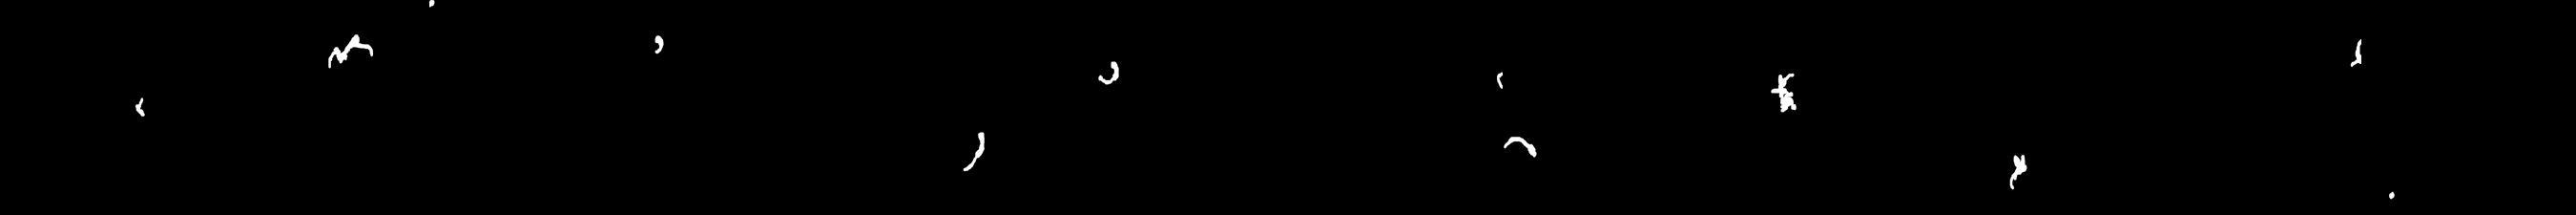

In [7]:
img, masks, labels = dead_dataset[4].values()
display_masks(masks)

Algunas comparaciones entre los datasets `cwt` y `dead`.

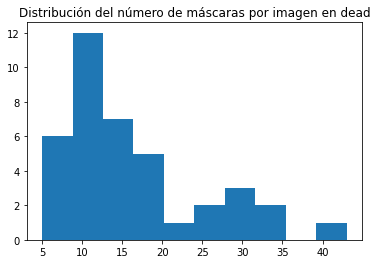

In [8]:
plt.hist(dead_dataset.get_number_of_masks());
plt.title('Distribución del número de máscaras por imagen en dead');

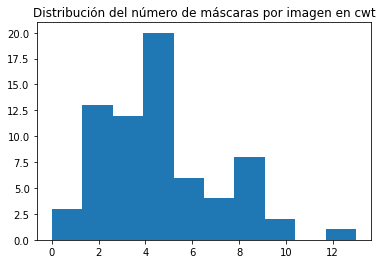

In [9]:
plt.hist(dataset.get_number_of_masks());
plt.title('Distribución del número de máscaras por imagen en cwt');

In [10]:
print("Masks per label in dead:")
dead_dataset.get_masks_per_labels()

Masks per label in dead:


(array(['dead', 'dead_cut', 'noise'], dtype='<U8'), array([163,  99, 364]))

In [11]:
print("Masks per label in cwt:")
dataset.get_masks_per_labels()

Masks per label in cwt:


(array(['noise', 'normal', 'normal_cut'], dtype='<U10'),
 array([119,  99,  98]))

In [12]:
print(f"Dead dataset: # de masks: {sum(dataset.get_number_of_masks())}, cantidad de obs: {len(dataset)}")

Dead dataset: # de masks: 316, cantidad de obs: 69


In [13]:
print(f"Dead dataset: # de masks: {sum(dead_dataset.get_number_of_masks())}, cantidad de obs: {len(dead_dataset)}")

Dead dataset: # de masks: 626, cantidad de obs: 39
